Checklist:
* make sure there are comments in every cell
* make sure all the libraries are just in the top of the notebook
* do not repeat code, define functions instead
* get mum to read through markdown cells
* make sure decision tree and random forest is destinctive labels ie dt_regressor, rf_regressor
* always say print(df) not just df

**Colours for Visuals** <br>
Green = Ireland <br>
Blue = France <br>
Yellow = Feed <br>
Orange = Cattle <br>

## Comparing beef prices for carcasses in Ireland and France
### A data science approach to investigation into the price of beef carcasses in Ireland and France using data from [European Commission](https://agridata.ec.europa.eu/extensions/DashboardBeef/BeefPricesExt.html#)
#### Naomi Tunstead - sba22222
#### MSc in Data Analytics
#### MSC_DA_CA2

In [7]:
#!pip install prettytable

In [8]:
# Read in libraries needed for analysis
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from datetime import timedelta
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prettytable import PrettyTable

In [9]:
# Define functions
def plot_histogram(df, column_name, title, xlabel):
    sns.histplot(data = df, x = column_name, bins = 20, kde = True, color = 'y')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    
def shapiro_test(x, color='green'):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val

def custom_density_plot(df, countries, y_col, main_title, xlabel, ylabel, density_plot_title, box_plot_title):
    # Create the subplots
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot the density plots
    colors = ['green', 'blue']
    for i, country in enumerate(countries):
        data = df[df['Member State'] == country][y_col]
        sns.kdeplot(data, color=colors[i], label=country, ax=ax[0])
    ax[0].set_title(density_plot_title)
    
    # Plot the box plots
    sns.boxplot(x='Member State', y=y_col, data=df, hue='Member State', palette=['green', 'blue'], ax=ax[1])
    ax[1].set_title(box_plot_title)
    
    # Create the Q-Q plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
    sm.qqplot(df[df['Member State'] == 'Ireland'][y_col], ax=ax[0], line='s', color='green')
    ax[0].set_title('Q-Q Plot of {} in Ireland'.format(ylabel))
    ax[0].set_xlabel('Theoretical Quantiles')
    ax[0].set_ylabel('Sample Quantiles')
    sm.qqplot(df[df['Member State'] == 'France'][y_col], ax=ax[1], line='s', color='blue')
    ax[1].set_title('Q-Q Plot of {} in France'.format(ylabel))
    ax[1].set_xlabel('Theoretical Quantiles')
    ax[1].set_ylabel('Sample Quantiles')
    
    # Set the main title of the figure
    fig.suptitle(main_title)
    
    # Perform the Shapiro-Wilk test on the data
    status, color, p_val = shapiro_test(df[y_col])
    
    # Set the title of the Q-Q plot figure to include the result of the normality test
    fig.suptitle('{} (p_value = {})'.format(status, p_val), color=color, fontsize=12)

In [10]:
# Read the xlsx files
df_cattle = pd.read_excel('ireland_france_2_years_beef.xlsx')
df_feed = pd.read_excel('barley_prices.xlsx')

In [11]:
# Print the cattle DataFrame
print(df_cattle)

      Year  Week Begin Date   End Date Member State      Category Product  \
0     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z O3   
1     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z O2   
2     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z U3   
3     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z R3   
4     2022    50 2022-12-12 2022-12-18      Ireland  Young cattle    Z R2   
...    ...   ...        ...        ...          ...           ...     ...   
6145  2021     3 2021-01-18 2021-01-24       France         Bulls    B R3   
6146  2021     2 2021-01-11 2021-01-17      Ireland         Bulls    B R3   
6147  2021     2 2021-01-11 2021-01-17       France         Bulls    B R3   
6148  2021     1 2021-01-04 2021-01-10      Ireland         Bulls    B R3   
6149  2021     1 2021-01-04 2021-01-10       France         Bulls    B R3   

       Price  
0     406.10  
1     416.31  
2     491.00  
3     497.31  


In [12]:
# Print the feed DataFrame
print(df_feed)

    Marketing Year Reference period Member State Product Name  \
0        2022/2023       2022-07-14       France  Feed barley   
1        2022/2023       2022-07-14      Ireland  Feed barley   
2        2022/2023       2022-07-21       France  Feed barley   
3        2022/2023       2022-07-21      Ireland  Feed barley   
4        2022/2023       2022-07-28       France  Feed barley   
..             ...              ...          ...          ...   
236      2020/2021       2021-06-17      Ireland  Feed barley   
237      2020/2021       2021-06-24       France  Feed barley   
238      2020/2021       2021-06-24      Ireland  Feed barley   
239      2020/2021       2021-07-01       France  Feed barley   
240      2020/2021       2021-07-01      Ireland  Feed barley   

                    Market Name  \
0                         Rouen   
1    Dublin/North East/Midlands   
2                         Rouen   
3    Dublin/North East/Midlands   
4                         Rouen   
..       

In [13]:
# Drop the 'End Date' and 'Week' column because its is not useful 
df_cattle = df_cattle.drop(columns=['End Date', 'Product'])

# Check result
print(df_cattle)

      Year  Week Begin Date Member State      Category   Price
0     2022    50 2022-12-12      Ireland  Young cattle  406.10
1     2022    50 2022-12-12      Ireland  Young cattle  416.31
2     2022    50 2022-12-12      Ireland  Young cattle  491.00
3     2022    50 2022-12-12      Ireland  Young cattle  497.31
4     2022    50 2022-12-12      Ireland  Young cattle  510.00
...    ...   ...        ...          ...           ...     ...
6145  2021     3 2021-01-18       France         Bulls  302.00
6146  2021     2 2021-01-11      Ireland         Bulls  272.63
6147  2021     2 2021-01-11       France         Bulls  301.00
6148  2021     1 2021-01-04      Ireland         Bulls  282.74
6149  2021     1 2021-01-04       France         Bulls  305.00

[6150 rows x 6 columns]


In [14]:
# Use df_cattle.describe() to get summary statistics of the data
# This can help us understand the distribution and overall characteristics of the data
pd.set_option('display.float_format', '{:.2f}'.format)

# Check result
print(df_cattle.describe())

         Year    Week   Price
count 6150.00 6150.00 6150.00
mean  2021.48   25.69  423.03
std      0.50   14.71   70.99
min   2021.00    1.00  182.00
25%   2021.00   13.00  375.02
50%   2021.00   25.00  420.93
75%   2022.00   38.00  473.93
max   2022.00   52.00  731.00


In [15]:
# Generate descriptive statistics of the data
pd.set_option('display.float_format', '{:.2f}'.format)

# Check result
print(df_feed.describe())

       Price (€/Tonne)
count           241.00
mean            260.91
std              69.64
min             161.50
25%             205.00
50%             240.00
75%             308.00
max             420.00


In [16]:
# Rename 'Begin Date' column to 'Reference period' so that we can used this column to merge the feed DataFrame
df_cattle = df_cattle.rename(columns={'Begin Date': 'Reference period'})

In [17]:
# Drop the 'Market Name', 'Stage Name' and 'Marketing Year' columns as they are not of interest
df_feed = df_feed.drop(columns=['Market Name', 'Stage Name', 'Marketing Year', 'Product Name'])

# Check result
print(df_feed)

    Reference period Member State  Price (€/Tonne)
0         2022-07-14       France           300.25
1         2022-07-14      Ireland           380.00
2         2022-07-21       France           300.25
3         2022-07-21      Ireland           325.00
4         2022-07-28       France           292.50
..               ...          ...              ...
236       2021-06-17      Ireland           238.00
237       2021-06-24       France           217.50
238       2021-06-24      Ireland           240.00
239       2021-07-01       France           204.50
240       2021-07-01      Ireland           240.00

[241 rows x 3 columns]


In [18]:
# Check the datatypes for each column and determine if they are correct or not
df_cattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150 entries, 0 to 6149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              6150 non-null   int64         
 1   Week              6150 non-null   int64         
 2   Reference period  6150 non-null   datetime64[ns]
 3   Member State      6150 non-null   object        
 4   Category          6150 non-null   object        
 5   Price             6150 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 288.4+ KB


In [19]:
# Check the datatypes for each column and determine if they are correct or not
df_feed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Reference period  241 non-null    datetime64[ns]
 1   Member State      241 non-null    object        
 2   Price (€/Tonne)   241 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.8+ KB


In [20]:
# Change all the Reference periods for df_feed to be 3 days previously to align them with the Reference period in df_cattle
df_feed["Reference period"] = df_feed["Reference period"].apply(lambda x: x - timedelta(days=3))

# Check result
print(df_feed)

    Reference period Member State  Price (€/Tonne)
0         2022-07-11       France           300.25
1         2022-07-11      Ireland           380.00
2         2022-07-18       France           300.25
3         2022-07-18      Ireland           325.00
4         2022-07-25       France           292.50
..               ...          ...              ...
236       2021-06-14      Ireland           238.00
237       2021-06-21       France           217.50
238       2021-06-21      Ireland           240.00
239       2021-06-28       France           204.50
240       2021-06-28      Ireland           240.00

[241 rows x 3 columns]


In [21]:
# Sort the DataFrame by the "Age" column in descending order
df_feed = df_feed.sort_values(by='Reference period', ascending=True)

In [22]:
# Set the maximum number of rows and columns to be displayed to 1000 in order to show the whole DataFrame to check results
# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000

# Check results
# df_feed

In [23]:
# Perform a left join on the two DataFrames
df = df_cattle.merge(df_feed, on=['Reference period', 'Member State'], how='left')

# Check result
print(df)

      Year  Week Reference period Member State      Category  Price  \
0     2022    50       2022-12-12      Ireland  Young cattle 406.10   
1     2022    50       2022-12-12      Ireland  Young cattle 416.31   
2     2022    50       2022-12-12      Ireland  Young cattle 491.00   
3     2022    50       2022-12-12      Ireland  Young cattle 497.31   
4     2022    50       2022-12-12      Ireland  Young cattle 510.00   
...    ...   ...              ...          ...           ...    ...   
6145  2021     3       2021-01-18       France         Bulls 302.00   
6146  2021     2       2021-01-11      Ireland         Bulls 272.63   
6147  2021     2       2021-01-11       France         Bulls 301.00   
6148  2021     1       2021-01-04      Ireland         Bulls 282.74   
6149  2021     1       2021-01-04       France         Bulls 305.00   

      Price (€/Tonne)  
0              298.00  
1              298.00  
2              298.00  
3              298.00  
4              298.00  
...

In [24]:
# Rename columns 'Price' and 'Price (€/Tonne)' to 'Cattle Price' and 'Feed Price (€/Tonne)' so there is no confusion
df = df.rename(columns={'Price': 'Cattle Price', 'Price (€/Tonne)': 'Feed Price (€/Tonne)'})

In [25]:
# Count the number of null values in each column
df.isnull().sum()

Year                      0
Week                      0
Reference period          0
Member State              0
Category                  0
Cattle Price              0
Feed Price (€/Tonne)    317
dtype: int64

In [26]:
# Drop the 'Reference period' as it has a data type of datetime64[ns] which may cause problem with our model later
df = df.drop(columns=['Reference period'])

In [27]:
# Swap 'Price' column to be target variable
df = df[['Year', 'Week', 'Member State', 'Feed Price (€/Tonne)', 'Category', 'Cattle Price']]

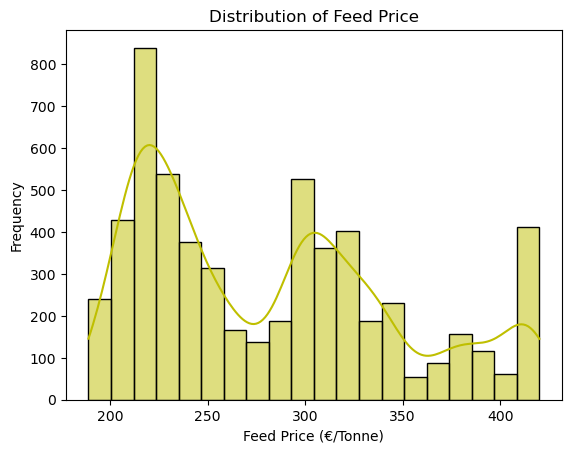

In [28]:
# Plot distribution of 'Price (€/Tonne)' before imputation of missing values
plot_histogram(df, 'Feed Price (€/Tonne)', 'Distribution of Feed Price', 'Feed Price (€/Tonne)')

# Save the image else where to be used in report
plt.savefig('./Images/Img1_before_imputation_histogram.svg')

In [29]:
# Forward fill the missing values in the "Price (€/Tonne)" column
df["Feed Price (€/Tonne)"].ffill(inplace=True)

# Check result
print(df)

      Year  Week Member State  Feed Price (€/Tonne)      Category  \
0     2022    50      Ireland                298.00  Young cattle   
1     2022    50      Ireland                298.00  Young cattle   
2     2022    50      Ireland                298.00  Young cattle   
3     2022    50      Ireland                298.00  Young cattle   
4     2022    50      Ireland                298.00  Young cattle   
...    ...   ...          ...                   ...           ...   
6145  2021     3       France                216.08         Bulls   
6146  2021     2      Ireland                197.00         Bulls   
6147  2021     2       France                204.08         Bulls   
6148  2021     1      Ireland                196.00         Bulls   
6149  2021     1       France                196.00         Bulls   

      Cattle Price  
0           406.10  
1           416.31  
2           491.00  
3           497.31  
4           510.00  
...            ...  
6145        302.00  
614

In [30]:
if df.isnull().any().any():
    print("There are nan values in the dataframe.")
else:
    print("There are no nan values in the dataframe.")

There are no nan values in the dataframe.


In [31]:
if df.isin([np.inf, -np.inf]).any().any():
    print("There are inf values in the dataframe.")
else:
    print("There are no inf values in the dataframe.")

There are no inf values in the dataframe.


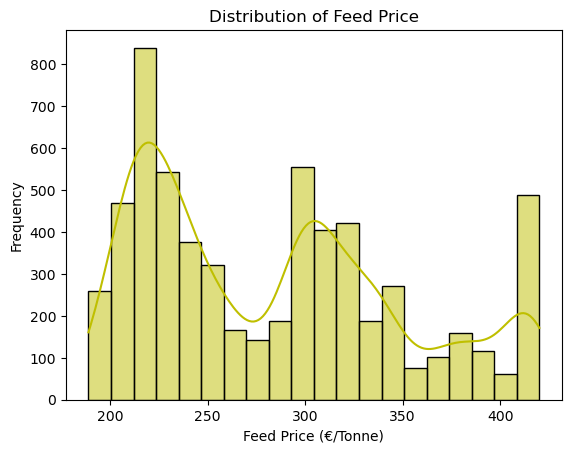

In [32]:
# Plot distribution of 'Price (€/Tonne)' to check for any change to distribution after imputation of missing values
plot_histogram(df, 'Feed Price (€/Tonne)', 'Distribution of Feed Price', 'Feed Price (€/Tonne)')

# Save the image else where to be used in report
plt.savefig('./Images/Img2_after_imputation_histogram.svg')

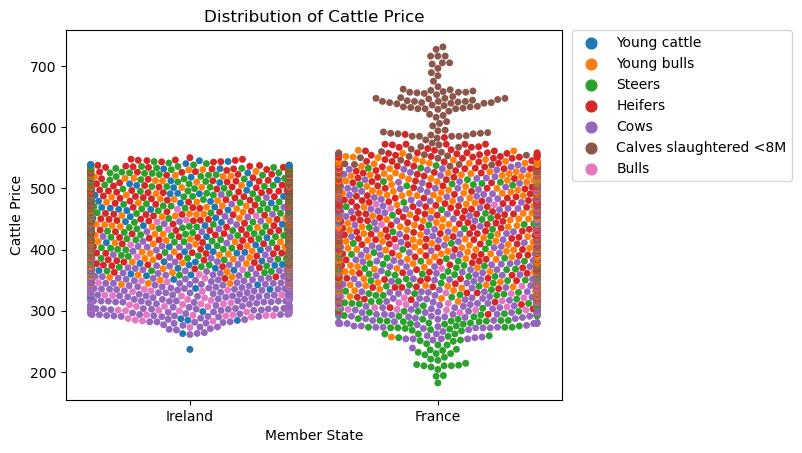

In [33]:
# Violin plot of price distribution of cattle by country
plt.title('Distribution of Cattle Price')
sns.swarmplot(data = df, x=df['Member State'], y=df['Cattle Price'], hue = 'Category')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

# Save the image else where to be used in report
plt.savefig('./Images/Img3_violin_plot.svg')

### Check to see if the data is linear before linear regression

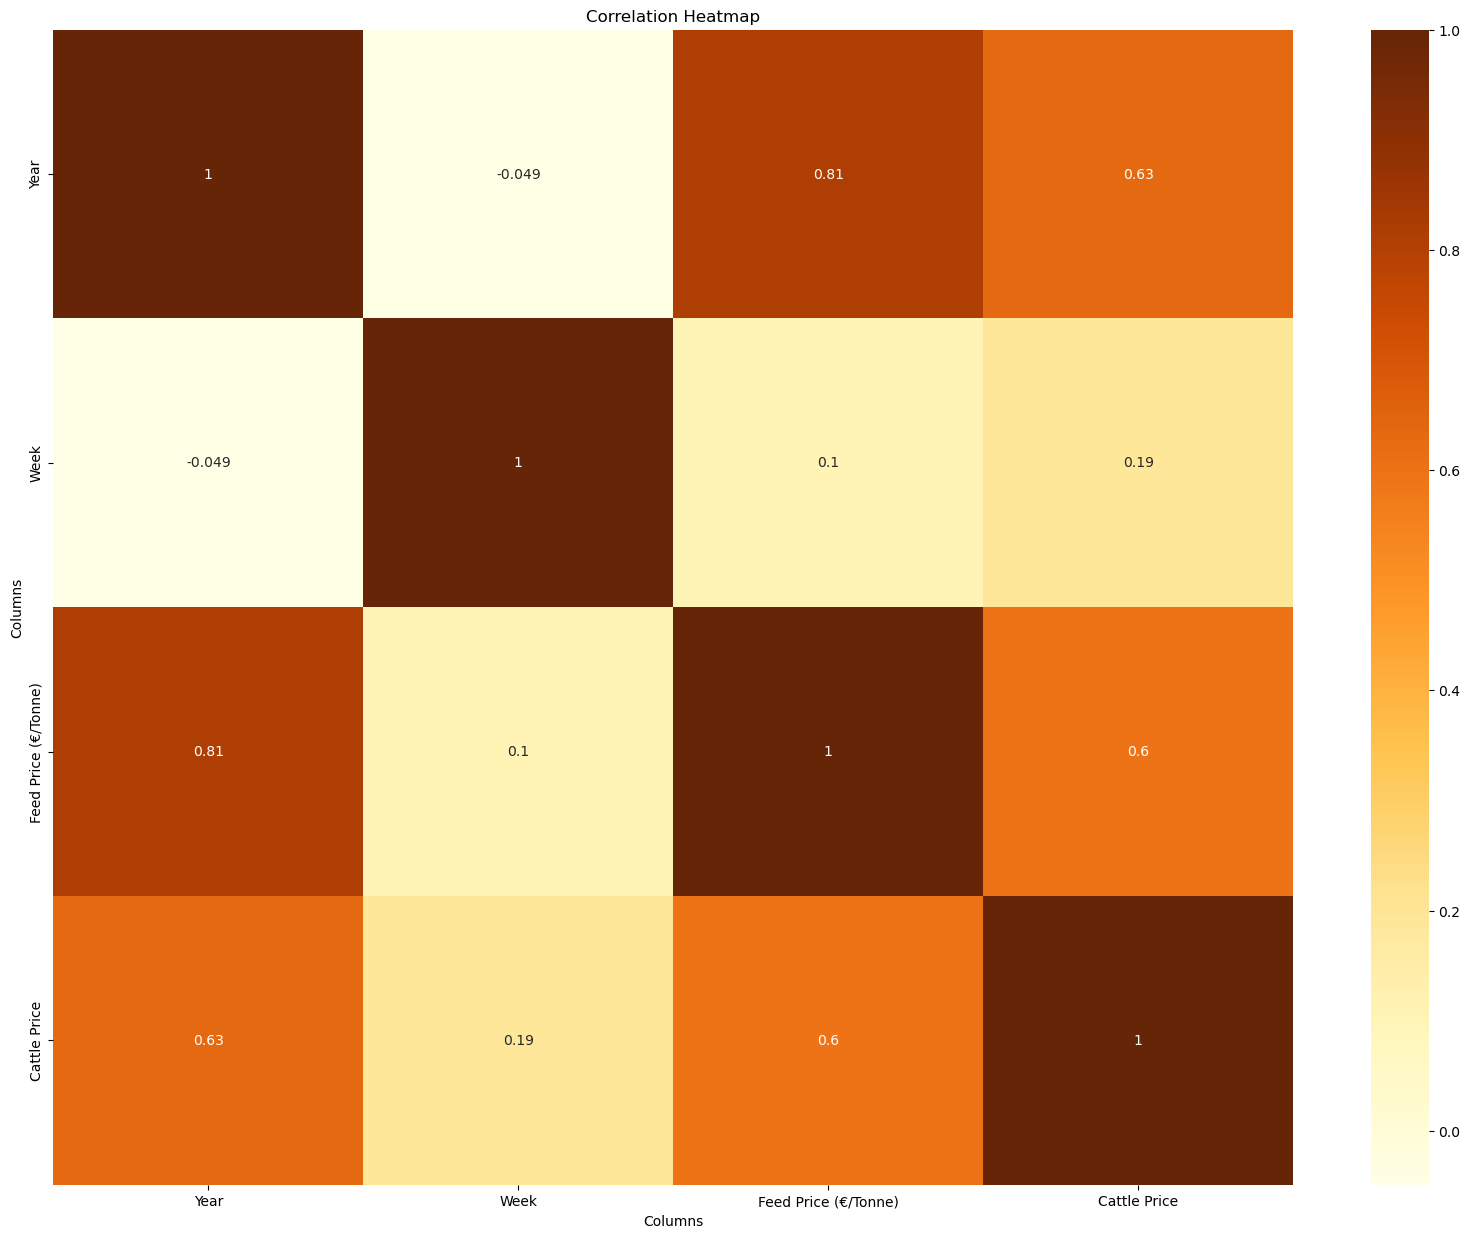

<Figure size 640x480 with 0 Axes>

In [34]:
# Compute the Pearson correlation between all pairs of columns
c_df = df.corr(method='pearson')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 15))

# Use the seaborn heatmap function to create a heatmap of the correlations
sns.heatmap(c_df, cmap='YlOrBr', annot=True)

# Set the plot title and labels
plt.title('Correlation Heatmap')
plt.xlabel('Columns')
plt.ylabel('Columns')

# Show the plot
plt.show()

# Save the image else where to be used in report
plt.savefig('./Images/Img4_pearson_corr_heatmap.svg')

The custom_barplot function is a custom function for visualizing the distribution of a column in a Pandas DataFrame. The function takes a DataFrame (df1) and a column name (col1) as input and creates a figure with four subplots: a histogram, a density plot, a Q-Q plot, and a box plot of the column.

The first two lines of the function check the size of the column and, if it has more than 5000 values, select a random sample of 5000 values from the column. This is done to avoid warnings about the size of the data being used with the Shapiro-Wilk test, which is unreliable with sample sizes larger than 5000, and for performance reasons.

The function then creates a figure and a 2x2 grid of subplots using plt.subplots. The histogram and density plot of the column are plotted using the plot method of the Pandas Series with the kind parameter set to 'hist' and 'kde', respectively. The Q-Q plot is created using the probplot function from the scipy.stats module. The box plot of the column is plotted using the plot method of the Pandas Series with the kind parameter set to 'box'.

Finally, the function calls the shapiro_test function to perform a Shapiro-Wilk test of normality on the column and returns the result as a tuple containing the status of the test (either 'Normal' or 'Not normal'), the color to use for the plot title, and the p-value of the test. The function then adds a plot title to the figure with the result of the normality test and the p-value.

There are a few ways you can improve the code:

Make the custom_barplot function more flexible by allowing it to accept multiple columns and countries, and to customize the title and labels of the plots. This way, you can use the function to create plots for different combinations of columns and countries without having to modify the function itself.

Use more descriptive and meaningful variable names. This can make the code easier to understand and maintain.

Use the seaborn library to create the plots. This library provides a variety of high-level plotting functions that can make your plots more visually appealing and easier to create.

Consider using the pandas plot method to create the plots. This method provides a convenient way to create various types of plots using the DataFrame and Series objects.

Use the matplotlib subplots function to create the plots. This function allows you to specify the number of rows and columns of subplots, and returns a tuple of the Figure and Axes objects. This can be more convenient than creating the plots manually.

Use matplotlib tight_layout function to adjust the layout of the plots. This can help avoid overlapping plots and text, and make the plots more visually appealing.

Consider using the scipy anderson_ksamp function to test for normality instead of the shapiro function. The anderson_ksamp

### Generate a Q-Q plot to compare the distribution of data to a theoretical distribution (e.g. normal)
### The plot shows the quantiles of the data against the quantiles of the theoretical distribution

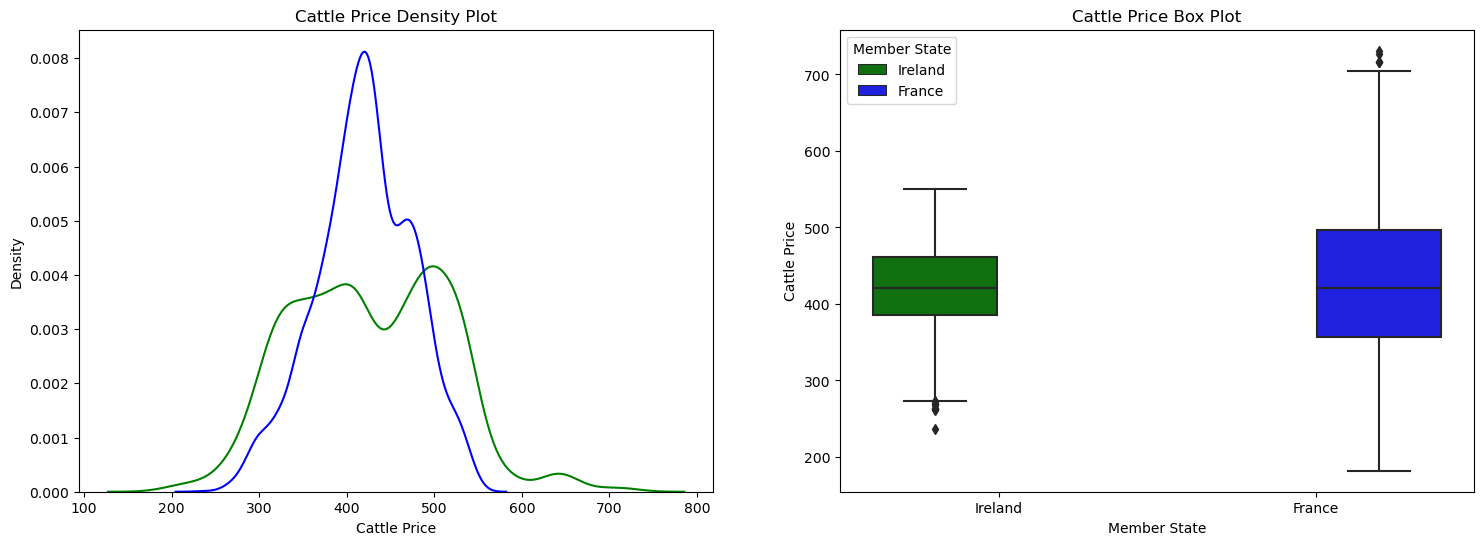

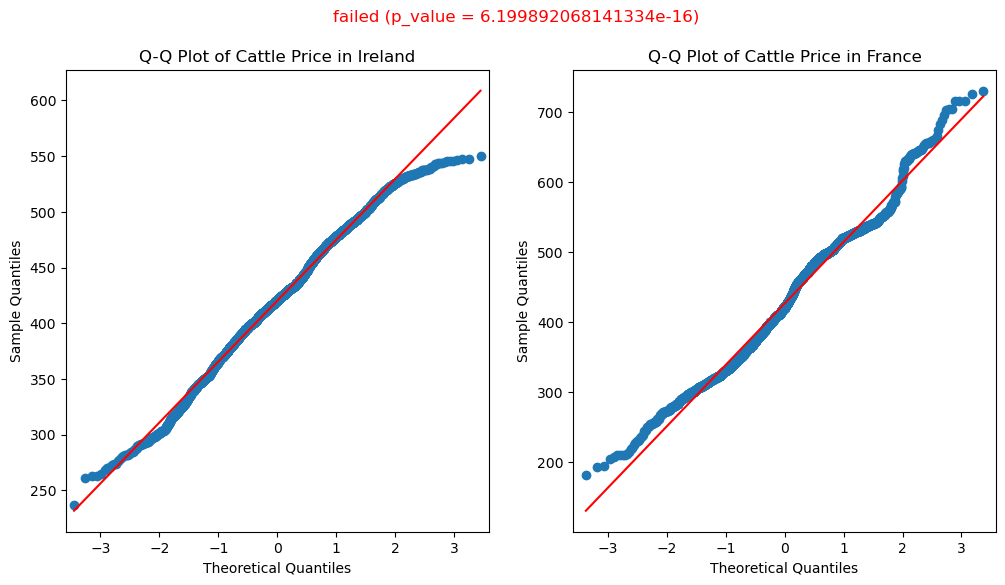

In [35]:
# Generate density plots, box plots and Q-Q plot for cattle prices in France and Ireland
# The density plots show the distribution of the data, the box plots provide summary statistics and use a Q-Q plot 
# to assess the normality of the data. If the data is normally distributed, the points on the plot should lie close
# to a straight line
density_plot_title = 'Cattle Price Density Plot'
box_plot_title = 'Cattle Price Box Plot'
custom_density_plot(df, ['France', 'Ireland'], 
                    'Cattle Price', 
                    'Q-Q Plots of Cattle Prices in Ireland and France', 
                    'Country', 
                    'Cattle Price',
                    density_plot_title, 
                    box_plot_title)

# Save the image else where to be used in report
plt.savefig('./Images/Img4_pearson_corr_cattle_price.svg')

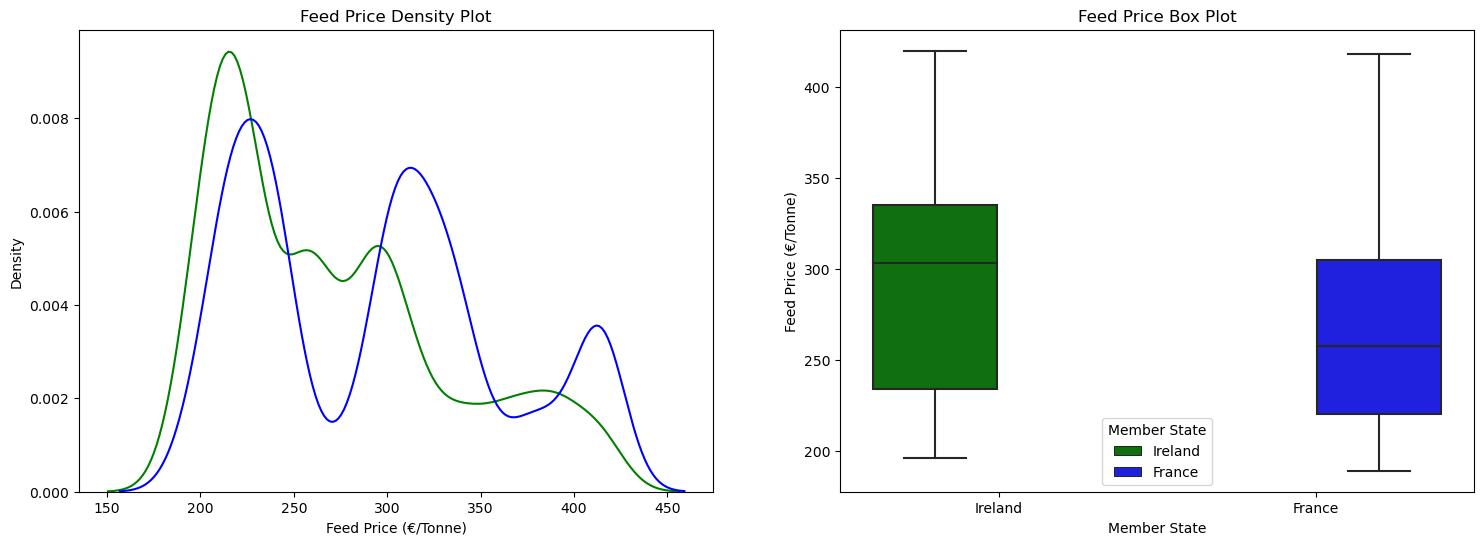

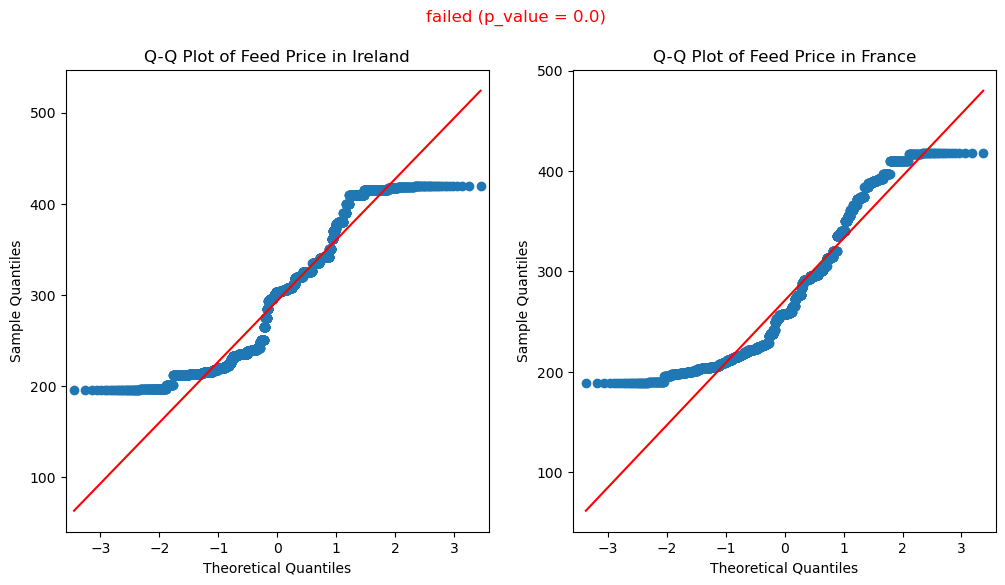

In [36]:
# Generate density plots, box plots and Q-Q plot for feed prices in France and Ireland
density_plot_title = 'Feed Price Density Plot'
box_plot_title = 'Feed Price Box Plot'
custom_density_plot(df, ['France', 'Ireland'], 
                    'Feed Price (€/Tonne)', 
                    'Q-Q Plots of Feed Prices in Ireland and France', 
                    'Country', 
                    'Feed Price',
                    density_plot_title, 
                    box_plot_title)

# Save the image else where to be used in report
plt.savefig('./Images/Img5_pearson_corr_feed_price.svg')

# Statistics

## Levene's test

To check if the variances of two samples are equal, you can use the Levene's test, which is a statistical test that compares the variances of two or more samples.

In [37]:
#H0 = varience are equal
#H1 = variance are not equal

In [38]:
# Extract columns for t-test
ireland_beef = df[df['Member State'] == 'Ireland']['Cattle Price']
france_beef = df[df['Member State'] == 'France']['Cattle Price']

# Perform Levene's test
statistic, p_value = stats.levene(ireland_beef, france_beef)

print("statistic: ", statistic)
print("p-value: ", p_value)

statistic:  845.756379549518
p-value:  2.4750342451812578e-174


If the p-value is less than the predetermined threshold, 0.05, you can conclude that the variances of the two samples are not equal. In that case, you may need to use a different statistical test that does not assume equal variances, such as the Welch's t-test or the Brown-Forsythe test. However our p-value is 2.48 which is greater than 0.05. Therefore, it means that the observed results are not statistically significant and it is not possible to reject the null hypothesis. This does not necessarily mean that the null hypothesis is true, but rather that the observed data do not provide sufficient evidence to reject the null hypothesis.

*It's important to note that the Levene's test assumes that the data are normally distributed. If this assumption is not met, you may need to use a different test to compare the variances of the two samples.*

## T-test

In [39]:
#H0 = means are equal
#H1 = means are not equal

In [40]:
# Perform t-test
t_statistic, p_value = stats.ttest_ind(ireland_beef, france_beef)

print("t-statistic: ", t_statistic)
print("p-value: ", p_value)

t-statistic:  -3.627042030759686
p-value:  0.0002890099620151181


## Non Parametric Test - Mann-Whitney U Test

#### H0 = no difference between the samples
#### H1 = there is a difference between the samples

In [41]:
ireland_feed = df[df['Member State'] == 'Ireland']['Feed Price (€/Tonne)']
france_feed = df[df['Member State'] == 'France']['Feed Price (€/Tonne)']

statistic, p_value = mannwhitneyu(ireland_feed, france_feed)

print("U-statistic: ", statistic)
print("p-value: ", p_value)

U-statistic:  5641434.5
p-value:  2.1911792964130366e-48


The U-statistic is a measure of the difference between the two samples, and the p-value is used to determine the statistical significance of the difference. If the p-value is less than 0.05, it can be concluded that there is a significant difference between the two samples.

The U-statistic is a measure of the difference between two samples in a Mann-Whitney U test. It is calculated as the sum of the ranks of the sample with the smaller size in the combined sample.

In the Mann-Whitney U test, the null hypothesis is that there is no difference between the two samples. The alternative hypothesis is that there is a difference between the samples. The U-statistic is used to determine the statistical significance of the difference between the samples.

If the U-statistic is small, it suggests that there is a significant difference between the samples. This is because a small U-statistic indicates that the ranks of the smaller sample are concentrated at the extremes of the combined sample, which suggests that the distributions of the two samples are different. On the other hand, if the U-statistic is large, it suggests that there is not a significant difference between the samples.

The U-statistic can be used in conjunction with the p-value to make a decision about the null hypothesis. If the p-value is less than 0.05, it can be concluded that there is a significant difference between the samples, and the null hypothesis can be rejected.

## Non Parametric Test - Wilcoxon Signed-rank test

not going to work because the samples are independent of each other

In [42]:
# from scipy.stats import wilcoxon

# statistic, p_value = wilcoxon(ireland_feed, france_feed)

# print("Wilcoxon statistic: ", statistic)
# print("p-value: ", p_value)

In [43]:
len(ireland_feed)

3508

In [44]:
len(france_feed)

2642

The Wilcoxon statistic is a measure of the difference between the two samples, and the p-value is used to determine the statistical significance of the difference. If the p-value is less than 0.05, it can be concluded that there is a significant difference between the two samples.

It's important to note that the Wilcoxon signed-rank test is used when the samples are related, meaning that the observations in one sample are paired with observations in the other sample. This test is not appropriate for independent samples.

## Non Parametric Test - Chi-Square Test

The hypothesis test for a chi-square test is used to determine if there is a significant association between two categorical variables. The null hypothesis is that there is no association between the two variables, and the alternative hypothesis is that there is an association between the variables.

To perform the test, a contingency table is created to summarize the counts of each combination of the two variables. The chi-square test is then applied to the contingency table to determine the statistical significance of the association between the variables.

If the p-value obtained from the chi-square test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant association between the two variables, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant association between the variables, and the null hypothesis is accepted.

It's important to note that the chi-square test is used to determine if there is a significant association between two categorical variables. It is not appropriate for continuous or ordinal variables.

In [45]:
# Create contingency table
table = pd.crosstab(df['Feed Price (€/Tonne)'], df['Cattle Price'])

statistic, p_value, degrees_of_freedom, expected = chi2_contingency(table)

print("Chi-square statistic: ", statistic)
print("p-value: ", p_value)
print("degrees of freedom: ", degrees_of_freedom)
print("expected frequencies: ", expected)

Chi-square statistic:  340866.6006007175
p-value:  1.0
degrees of freedom:  453822
expected frequencies:  [[0.00439024 0.00439024 0.00439024 ... 0.01317073 0.00439024 0.00439024]
 [0.00439024 0.00439024 0.00439024 ... 0.01317073 0.00439024 0.00439024]
 [0.00845528 0.00845528 0.00845528 ... 0.02536585 0.00845528 0.00845528]
 ...
 [0.00910569 0.00910569 0.00910569 ... 0.02731707 0.00910569 0.00910569]
 [0.0100813  0.0100813  0.0100813  ... 0.0302439  0.0100813  0.0100813 ]
 [0.00569106 0.00569106 0.00569106 ... 0.01707317 0.00569106 0.00569106]]


The chi-square statistic is a measure of the difference between the observed and expected frequencies in the contingency table. It is calculated as the sum of the squared differences between the observed and expected frequencies, divided by the expected frequencies. The larger the chi-square statistic, the stronger the evidence against the null hypothesis (i.e., the more evidence there is for a significant association between the variables).

The p-value is used to determine the statistical significance of the association between the variables. It is the probability of obtaining a chi-square statistic as large as or larger than the observed value, given that the null hypothesis is true. If the p-value is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant association between the two variables, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant association between the variables, and the null hypothesis is accepted.

The degrees of freedom for a chi-square test are equal to the number of rows in the contingency table minus 1 multiplied by the number of columns in the table minus 1. The degrees of freedom are used to determine the critical value of the chi-square statistic, which is used to determine the p-value.

The expected frequencies are the frequencies that would be expected in each cell of the contingency table if the null hypothesis were true. They are calculated by taking the product of the row and column totals and dividing by the sample size. The expected frequencies are used to calculate the chi-square statistic and determine the statistical significance of the association between the variables.

## Fisher's Extract Test

The hypothesis test for a Fisher's exact test is used to determine if there is a significant association between two categorical variables. The null hypothesis is that there is no association between the two variables, and the alternative hypothesis is that there is an association between the variables.

To perform the test, a contingency table is created to summarize the counts of each combination of the two variables. The Fisher's exact test is then applied to the contingency table to determine the statistical significance of the association between the variables.

If the p-value obtained from the Fisher's exact test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant association between the two variables, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant association between the variables, and the null hypothesis is accepted.

It's important to note that the Fisher's exact test is used when the sample size is small or when the expected frequencies in the contingency table are small. It is not as powerful as the chi-square test for larger samples.

In [46]:
# from scipy.stats import fisher_exact

# # Create contingency table
# table = pd.crosstab(df['Product'], df['Price'])

# odds_ratio, p_value = fisher_exact(table)

# print("Odds ratio: ", odds_ratio)
# print("p-value: ", p_value)

The sample size for a Fisher's exact test is considered small when the expected frequencies in the contingency table are less than 5. When the expected frequencies are less than 5, the chi-square test may not be reliable due to the underlying assumptions of the test. In such cases, the Fisher's exact test is a more appropriate alternative.

It's important to note that the Fisher's exact test is generally less powerful than the chi-square test, which means that it may be less able to detect significant differences between the observed and expected frequencies in the contingency table. As a result, it is generally recommended to use the chi-square test when the sample size is larger and the expected frequencies are greater than 5.

It's also worth noting that the sample size for a statistical test is not the only factor that should be considered when deciding which test to use. Other factors, such as the nature of the data and the research question being addressed, should also be taken into account.

## F-test

The hypothesis test for an F-test is used to determine if there is a significant difference between the means of two or more groups. The null hypothesis is that there is no difference between the means of the groups, and the alternative hypothesis is that there is a difference between the means of the groups.

To perform the test, the F-statistic is calculated as the ratio of the mean square between groups (MSB) to the mean square within groups (MSW). The p-value is then calculated using the F-distribution, which is the distribution of the F-statistic under the null hypothesis.

If the p-value obtained from the F-test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant difference between the means of the groups, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant difference between the means of the groups, and the null hypothesis is accepted.

It's important to note that the F-test is used to compare the means of two or more groups. It is not appropriate for comparing the means of two pairs of samples. To compare the means of two pairs of samples, you can use a t-test or a paired t-test.

In [47]:
# Perform F-test
statistic, p_value = f_oneway(ireland_beef, france_beef)

print("F-statistic: ", statistic)
print("p-value: ", p_value)

F-statistic:  13.155433892897271
p-value:  0.0002890099620148141


The F-statistic is a measure of the ratio of the variance between the groups to the variance within the groups. It is calculated as the ratio of the mean square between groups (MSB) to the mean square within groups (MSW). The larger the F-statistic, the stronger the evidence against the null hypothesis (i.e., the more evidence there is for a significant difference between the means of the groups).

The p-value is used to determine the statistical significance of the difference between the means of the groups. It is the probability of obtaining an F-statistic as large as or larger than the observed value, given that the null hypothesis is true. If the p-value is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant difference between the means of the groups, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant difference between the means of the groups, and the null hypothesis is accepted.

## Anova

Assumptions
1. Independence
2. Normally disributed
3. Quality of Variance

#### H0 = means are equal
#### H1 = at least one is not equal

One-way ANOVA and two-way ANOVA are both statistical tests used to compare the means of groups. The main difference between the two tests is the number of independent variables being considered.

One-way ANOVA is used to compare the means of three or more groups, where there is only one independent variable. For example, if you want to compare the mean heights of three different species of plants, species would be the independent variable, and height would be the dependent variable. One-way ANOVA is used to determine if there is a significant difference in the mean heights of the plants due to the effect of the species.

Two-way ANOVA is used to compare the means of groups, where there are two independent variables. For example, if you want to compare the mean heights of plants grown in two different soil types and exposed to two different levels of sunlight, soil type and sunlight exposure would be the independent variables, and height would be the dependent variable. Two-way ANOVA is used to determine if there is a significant difference in the mean heights of the plants due to the combined effects of the soil type and sunlight exposure.

Both one-way ANOVA and two-way ANOVA involve testing the null hypothesis that there is no difference between the means of the groups. If the p-value obtained from the test is less than the chosen significance level (typically 0.05), it can be concluded that there is a significant difference between the means of the groups, and the null hypothesis can be rejected. On the other hand, if the p-value is greater than the significance level, it can be concluded that there is not a significant difference between the means of the groups, and the null hypothesis is accepted.

# Machine Learning

## Supervised Learning

models to use on continuous data
There are several machine learning models that are well suited for working with continuous data. Some common options include:

Linear regression: Linear regression is a simple and widely used model that is used to predict a continuous target variable based on one or more continuous or categorical features. It is well suited for working with continuous data and can be used for both regression and classification tasks.

Ridge regression: Ridge regression is a variant of linear regression that introduces a regularization term to the model to prevent overfitting. It is well suited for working with continuous data and can be used for both regression and classification tasks.

Lasso regression: Lasso regression is another variant of linear regression that introduces a regularization term to the model to prevent overfitting. It is well suited for working with continuous data and can be used for both regression and classification tasks.

Support vector machines (SVMs): SVMs are a type of linear model that is commonly used for classification tasks. They are well suited for working with continuous data, as they can handle both continuous and categorical features and can be used for both classification and regression tasks.

Decision trees: Decision trees are a type of tree-based model that can be used for both classification and regression tasks. They are well suited for working with continuous data, as they can handle both continuous and categorical features.

Random forests: Random forests are an ensemble learning method that combines multiple decision trees to make predictions. Like decision trees, they are well suited for working with continuous data and can be used for both classification and regression tasks.

Ultimately, the choice of model will depend on the specific problem you are trying to solve and the characteristics of your dataset. It is a good idea to try a few different models and evaluate their performance on your dataset to determine which model is the best fit for your problem.

In [48]:
df = pd.get_dummies(df, columns=['Member State', 'Category'])

# Create the independent and dependent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

The R2 score, also known as the coefficient of determination, is a measure of how well the model fits the data. It is defined as the proportion of the variance in the target variable that is explained by the model. An R2 score of 1.0 indicates that the model perfectly fits the data, while an R2 score of 0.0 indicates that the model does not explain any of the variance in the target variable.

The mean absolute error (MAE) is a measure of the average magnitude of the errors in the model's predictions. It is calculated as the average absolute difference between the predicted values and the true values. A smaller MAE score indicates that the model's predictions are closer to the true values on average.

The mean squared error (MSE) is a measure of the average squared difference between the predicted values and the true values. It is generally preferred over the MAE because it penalizes larger errors more heavily. A smaller MSE score indicates that the model's predictions are closer to the true values on average.

The root mean squared error (RMSE) is the square root of the MSE, and is expressed in the same units as the target variable. It is a more interpretable measure of error, as it is expressed in the same units as the target variable. Like the MSE, a smaller RMSE score indicates that the model's predictions are closer to the true values on average.

Based on the scores you provided, it looks like the model is performing very well, with an R2 score of 1.0 and very small MAE, MSE, and RMSE scores. This suggests that the model is able to accurately fit the data and make very accurate predictions. It is worth noting, however, that these scores should be interpreted in the context of the problem you are trying to solve and the characteristics of your dataset. A model with excellent performance on one dataset may not necessarily perform as well on a different dataset.

In [57]:
def model_data(X_train, y_train, X_test, y_test):
    """Models data with decision tree, random forest, linear regression,
    ridge, lasso, and gradient boosting.
    
    Parameters:
        X_train (ndarray): Training data features.
        y_train (ndarray): Training data labels.
        X_test (ndarray): Test data features.
        y_test (ndarray): Test data labels.
    
    Returns:
        dict: Dictionary with the evaluation scores of the different models.
         """
    # Create a dictionary to store the results
    results = {}
    
    # Decision Tree
    # Define the hyperparameter space for decision tree
    dt_param_grid = {'max_depth': [3, 5, 7, 9, None],
                     'min_samples_split': [2, 4, 6, 8, 10],
                     'min_samples_leaf': [1, 3, 5, 7, 9]}
    
    # Create a grid search object for decision tree
    dt_grid_search = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=dt_param_grid, cv=5)
    
    # Fit the grid search object to the training data
    dt_grid_search.fit(X_train, y_train)
    
    # Train the model on the entire dataset using the best parameters
    dt_regressor = DecisionTreeRegressor(**dt_grid_search.best_params_)
    dt_regressor.fit(X, y)

    # Calculate the predicted value by calling a method predict()
    y_pred = dt_regressor.predict(X_test)
    
    # Evaluate the model
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    train_score = dt_regressor.score(X_train, y_train)
    test_score = dt_regressor.score(X_test, y_test)
    r2 = metrics.r2_score(y_test, y_pred)
    results['Decision Tree'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Train Score': train_score, 
                                'Test Score': test_score, 'R2': r2}
    
    # Random Forest
    # Define the hyperparameter space for random forest
    rf_param_grid = {'n_estimators': [10, 50, 100, 200, 300],
                     'max_depth': [3, 5, 7, 9, None],
                     'min_samples_split': [2, 4, 6, 8, 10],
                     'min_samples_leaf': [1, 3, 5, 7, 9]}
    
    # Create a grid search object for random forest
    rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_param_grid, cv=5)
    
    # Fit the grid search object to the training data
    rf_grid_search.fit(X_train, y_train)
    
    # Train the model on the entire dataset using the best parameters
    rf_regressor = RandomForestRegressor(**rf_grid_search.best_params_)
    rf_regressor.fit(X, y)

    # Calculate the predicted value by calling a method predict()
    y_pred = rf_regressor.predict(X_test)
    
    # Evaluate the model
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    train_score = rf_regressor.score(X_train, y_train)
    test_score = rf_regressor.score(X_test, y_test)
    r2 = metrics.r2_score(y_test, y_pred)
    results['Random Forest'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Train Score': train_score, 
                                'Test Score': test_score, 'R2': r2}
    
    # Linear Regression
    # Model data with linear regression
    lr_model = LinearRegression()
    
    # Define the hyperparameter space for linear regression
    lr_param_grid = {'normalize': [True, False],
                     'fit_intercept': [True, False]}
    
    # Create a grid search object for linear regression
    lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid, cv=10)
   
    # Train the model and search for the best hyperparameters
    lr_grid_search.fit(X_train, y_train)
    
    # Train the model on the entire dataset using the best parameters
    linear_model = LinearRegression(**lr_grid_search.best_params_)
    linear_model.fit(X, y)

    # Make predictions
    y_pred = linear_model.predict(X_test)
    
    # Evaluate the model
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    train_score = linear_model.score(X_train, y_train)
    test_score = linear_model.score(X_test, y_test)
    r2 = metrics.r2_score(y_test, y_pred)
    results['Linear Regression'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Train Score': train_score, 
                                'Test Score': test_score, 'R2': r2}
    
    # Ridge Regression
    # Define the hyperparameter space for ridge regression
    ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                        'normalize': [True, False],
                        'fit_intercept': [True, False]}
    
    # Create a grid search object for ridge regression
    ridge_grid_search = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv=5)
    
    # Fit the grid search object to the training data
    ridge_grid_search.fit(X_train, y_train)
    
    # Train the model on the entire dataset using the best parameters
    ridge_regressor = Ridge(**ridge_grid_search.best_params_)
    ridge_regressor.fit(X, y)

    # Make predictions
    y_pred = ridge_regressor.predict(X_test)
    
    # Evaluate the model
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    train_score = ridge_regressor.score(X_train, y_train)
    test_score = ridge_regressor.score(X_test, y_test)
    r2 = metrics.r2_score(y_test, y_pred)
    results['Ridge Regression'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Train Score': train_score, 
                                'Test Score': test_score, 'R2': r2}
    
    # Lasso Regression
    # Define the hyperparameter space for lasso regression
    lasso_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                        'normalize': [True, False],
                        'fit_intercept': [True, False]}
    
    # Create a grid search object for lasso regression
    lasso_grid_search = GridSearchCV(estimator=Lasso(), param_grid=lasso_param_grid, cv=10)

    # Fit the grid search object to the training data
    lasso_grid_search.fit(X_train, y_train)
    
    # Train the model on the entire dataset using the best parameters
    lasso_regressor = Lasso(**lasso_grid_search.best_params_)
    lasso_regressor.fit(X, y)
    
    # Make predictions
    y_pred = lasso_regressor.predict(X_test)
    
    # Evaluate the model
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    train_score = lasso_regressor.score(X_train, y_train)
    test_score = lasso_regressor.score(X_test, y_test)
    r2 = metrics.r2_score(y_test, y_pred)
    results['Lasso Regression'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Train Score': train_score, 
                                'Test Score': test_score, 'R2': r2}
    
    # Gradient Boosting
    # Define the hyperparameter space for gradient boosting
    gb_param_grid = {'loss': ['ls', 'lad', 'huber', 'quantile'],
                     'learning_rate': [0.01, 0.1, 1.0, 10.0, 100.0],
                     'n_estimators': [10, 50, 100, 200, 300],
                     'max_depth': [3, 5, 7, 9, None],
                     'min_samples_split': [2, 4, 6, 8, 10],
                     'min_samples_leaf': [1, 3, 5, 7, 9]}
    # Create a grid search object for gradient boosting
    gb_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gb_param_grid, cv=5)
    
    # Fit the grid search object to the training data
    gb_grid_search.fit(X_train, y_train)
    
    # Train the model on the entire dataset using the best parameters
    gb_regressor = GradientBoostingRegressor(**gb_grid_search.best_params_)
    gb_regressor.fit(X, y)

    # Make predictions
    y_pred = gb_regressor.predict(X_test)
    
    # Evaluate the model
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    train_score = gb_regressor.score(X_train, y_train)
    test_score = gb_regressor.score(X_test, y_test)
    r2 = metrics.r2_score(y_test, y_pred)
    results['Gradient Boosting'] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'Train Score': train_score, 
                                'Test Score': test_score, 'R2': r2}
    
    return results


In [58]:
# Call the model_data() function and pass it the training and test data
results = model_data(X_train, y_train, X_test, y_test)

# Initialize a table with the desired column names
table = PrettyTable(['Model', 'MAE', 'MSE', 'RMSE', 'Train Score', 'Test Score','R2'])

# Iterate over the results and add a row for each model
for model, scores in results.items():
    table.add_row([model, scores['MAE'], scores['MSE'], scores['RMSE'], scores['Train Score'], 
                   scores['Test Score'], scores['R2']])

# Print the table
print(table)

KeyboardInterrupt: 

In general, a model with a low MAE, MSE, and RMSE and a high R2 score is considered to be performing well. However, you should also consider other factors such as the complexity of the model, the time it takes to train and make predictions, and its ability to generalize to new data.

In this case, it looks like the Decision Tree and Random Forest models have the lowest error metrics, but their R2 scores are not as high as the other models. The Linear Regression, Ridge Regression, and Lasso models have lower error metrics and higher R2 scores, but they may be more complex and take longer to train. The Gradient Boosting model has intermediate values for the error metrics and the R2 score.

In [ ]:
# Set the size of the figure
plt.figure(figsize = (12, 8))

# Display the tree by calling a method plot_tree()
tree.plot_tree(dt_regressor.fit(X_train, y_train),filled=True, rounded=True, precision=2) ;

# Save the image else where to be used in report
plt.savefig('./Images/Img4_pearson_corr_heatmap.svg')

## Unsupervised Learning

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

if y.ndim == 1:
    y = y.reshape(-1, 1)

# Remove the target variable
X = df.drop(columns=['Cattle Price'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the hyperparameter space for the unsupervised learning algorithm
param_grid = {'n_components': [2, 3, 4],
              'n_clusters': [2, 3, 4]}

# Define a scoring function
def scoring_function(estimator, X, y):
    clusters = estimator.predict(X)
    return metrics.silhouette_score(X, clusters)

# Create a grid search object
clustering_grid_search = GridSearchCV(estimator=KMeans(), param_grid=param_grid, cv=5, scoring=scoring_function)

# Fit the grid search object to the training data
clustering_grid_search.fit(X_scaled, y)

# Train the model on the entire dataset using the best parameters
best_clustering = KMeans(**clustering_grid_search.best_params_)
best_clustering.fit(X_scaled)

# Calculate the predicted value by calling a method predict()
y_pred = best_clustering.predict(X_scaled)

ValueError: Invalid parameter n_components for estimator KMeans(n_clusters=2). Check the list of available parameters with `estimator.get_params().keys()`.

This code uses k-means for clustering and grid search CV to find the optimal number of clusters. The code also defines a scoring function based on the silhouette score, which is a measure of how well each point is assigned to its own cluster.

In [83]:
from sklearn.decomposition import PCA

# Define the hyperparameter space for the unsupervised learning algorithm
param_grid = {'n_components': [2, 3, 4],
              'alpha': [0.1, 0.5, 1.0]}

# Define a scoring function
def scoring_function(estimator, X, y):
    return metrics.calinski_harabasz_score(X, estimator.transform(X))

# Create a grid search object
pca_grid_search = GridSearchCV(estimator=PCA(), param_grid=param_grid, cv=5, scoring=scoring_function)

# Fit the grid search object to the training data
pca_grid_search.fit(X_scaled, y)

# Train the model on the entire dataset using the best parameters
best_pca = PCA(**pca_grid_search.best_params_)
best_pca.fit(X_scaled)

# Calculate the explained variance ratio
explained_variance = best_pca.explained_variance_ratio_

ValueError: Invalid parameter alpha for estimator PCA(). Check the list of available parameters with `estimator.get_params().keys()`.

This code uses principal component analysis (PCA) for dimensionality reduction and grid search CV to find the optimal number of components. The code also defines a scoring function based on the Calinski-Harabasz score, which is a measure of the compactness of the clusters.

In [71]:
# Worked
# Define the hyperparameter space for the clustering algorithm
param_grid = {'n_clusters': [2, 3, 4, 5],
              'tol': [1e-4, 1e-3, 1e-2]}

# Define a scoring function
def scoring_function(estimator, X, y):
    return metrics.calinski_harabasz_score(X, estimator.predict(X))

# Create a grid search object
kmeans_grid_search = GridSearchCV(estimator=KMeans(), param_grid=param_grid, cv=5, scoring=scoring_function)

# Fit the grid search object to the training data
kmeans_grid_search.fit(X_scaled)

# Train the model on the entire dataset using the best parameters
best_kmeans = KMeans(**kmeans_grid_search.best_params_)
best_kmeans.fit(X_scaled)

# Calculate the cluster assignments
cluster_assignments = best_kmeans.predict(X_scaled)
cluster_assignments

array([0, 0, 0, ..., 1, 0, 1])

This code uses the k-means clustering algorithm and grid search CV to find the optimal number of clusters. The code also defines a scoring function based on the Calinski-Harabasz score, which is a measure of the compactness and separation of the clusters.

In [73]:
# Define the hyperparameter space for the unsupervised learning algorithm
param_grid = {'n_clusters': [2, 3, 4],
              'max_iter': [100, 200, 300]}

# Define a scoring function
def scoring_function(estimator, X, y):
    return metrics.silhouette_score(X, estimator.predict(X))

# Create a grid search object
kmeans_grid_search = GridSearchCV(estimator=KMeans(), param_grid=param_grid, cv=5, scoring=scoring_function)

# Fit the grid search object to the training data
kmeans_grid_search.fit(X_scaled)

# Train the model on the entire dataset using the best parameters
best_kmeans = KMeans(**kmeans_grid_search.best_params_)
best_kmeans.fit(X_scaled)

# Calculate the cluster assignments
cluster_assignments = best_kmeans.predict(X_scaled)
cluster_assignments

array([1, 1, 1, ..., 0, 1, 0])

This code uses k-means clustering for data partitioning and grid search CV to find the optimal number of clusters. The code also defines a scoring function based on the silhouette score, which is a measure of the compactness and separation of the clusters.

In [78]:
from sklearn.decomposition import PCA

# Define the hyperparameter space for the unsupervised learning algorithm
param_grid = {'n_components': [2, 3, 4, 5],
              'tol': [1e-4, 1e-3, 1e-2]}

# Define a scoring function
def scoring_function(estimator, X, y):
    return metrics.silhouette_score(X, estimator.transform(X))

# Create a grid search object
pca_grid_search = GridSearchCV(estimator=PCA(), param_grid=param_grid, cv=5, scoring=scoring_function)

# Fit the grid search object to the training data
pca_grid_search.fit(X_scaled)

# Train the model on the entire dataset using the best parameters
best_pca = PCA(**pca_grid_search.best_params_)
best_pca.fit(X_scaled)

# Calculate the principal components
principal_components = best_pca.transform(X_scaled)

This code uses principal component analysis (PCA) for dimensionality reduction and grid search CV to find the optimal number of components. The code also defines a scoring function based on the silhouette score, which is a measure of the compactness and separation of the data points in the reduced-dimensional space.

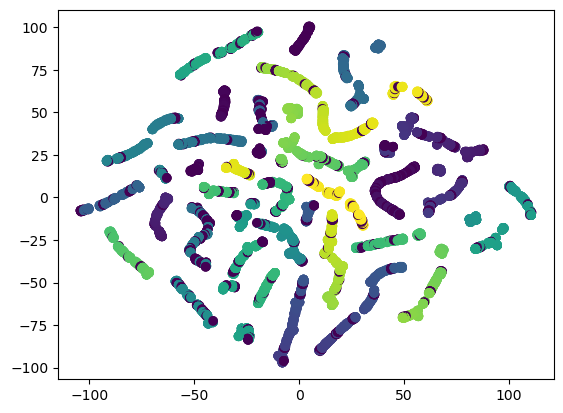

In [80]:
from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# Apply a dimensionality reduction algorithm
tsne = TSNE(n_components=2)
X_reduced = tsne.fit_transform(X_scaled)

# Apply a clustering algorithm
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_reduced)

# Visualize the results
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters)
plt.show()

This code is similar to the previous example, but it uses t-distributed stochastic neighbor embedding (t-SNE) for dimensionality reduction and DBSCAN for clustering. The code also visualizes the results by plotting the data points with colors indicating the cluster to which each point belongs.

In [81]:
# Define the hyperparameter space for t-SNE
param_grid = {'perplexity': [5, 10, 20, 30, 50],
              'learning_rate': [10, 50, 100, 200]}

# Create a grid search object for t-SNE
tsne_grid_search = GridSearchCV(estimator=TSNE(), param_grid=param_grid, cv=5)

# Fit the grid search object to the training data
tsne_grid_search.fit(X_scaled)

# Train the model on the entire dataset using the best parameters
best_tsne = TSNE(**tsne_grid_search.best_params_)
X_tsne = best_tsne.fit_transform(X_scaled)

# Define the hyperparameter space for DBSCAN
param_grid = {'eps': [0.5, 1, 1.5, 2],
              'min_samples': [5, 10, 15, 20]}

# Create a grid search object for DBSCAN
dbscan_grid_search = GridSearchCV(estimator=DBSCAN(), param_grid=param_grid, cv=5)

# Fit the grid search object to the t-SNE transformed data
dbscan_grid_search.fit(X_tsne)

# Train the model on the entire dataset using the best parameters
best_dbscan = DBSCAN(**dbscan_grid_search.best_params_)
best_dbscan.fit(X_tsne)

# Calculate the predicted clusters
clusters = best_dbscan.labels_

# Print the results
#print("Optimal

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters)
plt.show()

# Check the performance of the model using metrics such as homogeneity, completeness, and V-measure
print(metrics.homogeneity_score(df['target'], clusters))
print(metrics.completeness_score(df['target'], clusters))
print(metrics.v_measure_score(df['target'], clusters))
      

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator TSNE() does not.

This code uses the t-SNE and DBSCAN algorithms, along with grid search CV, to find the optimal parameters for dimensionality reduction and clustering, respectively. The code first standardizes the data, then applies t-SNE to reduce the dimensionality of the data to two dimensions. The resulting t-SNE transformed data is then used as input to the DBSCAN algorithm, which clusters the data into different groups based on the specified parameters.

This code first visualizes the results of the clustering by plotting the t-SNE transformed data points with colors representing the predicted clusters. It then calculates and prints some evaluation metrics for the clustering model, such as homogeneity, completeness, and V-measure.

In [82]:
from sklearn.ensemble import IsolationForest


# Define the hyperparameter space for the anomaly detection algorithm
param_grid = {'contamination': [0.1, 0.2, 0.3],
              'support_fraction': [0.5, 0.6, 0.7]}

# Define a scoring function
def scoring_function(estimator, X, y):
    return metrics.roc_auc_score(y, estimator.decision_function(X))

# Create a grid search object
isolation_forest_grid_search = GridSearchCV(estimator=IsolationForest(), param_grid=param_grid, cv=5, scoring=scoring_function)

# Fit the grid search object to the training data
isolation_forest_grid_search.fit(X_scaled)

# Train the model on the entire dataset using the best parameters
best_isolation_forest = IsolationForest(**isolation_forest_grid_search.best_params_)
best_isolation_forest.fit(X_scaled)

# Calculate the predicted scores
scores = best_isolation_forest.decision_function(X_scaled)

ValueError: Invalid parameter support_fraction for estimator IsolationForest(contamination=0.1). Check the list of available parameters with `estimator.get_params().keys()`.

This code uses the Isolation Forest algorithm and grid search CV to find the optimal contamination level and support fraction parameters for anomaly detection. The code also defines a scoring function based on the area under the ROC curve (AUC), which is a measure of the model's ability to distinguish between normal and anomalous samples.

You can modify this code to use different anomaly detection algorithms and scoring functions as needed, depending on the nature of the data and the specific patterns or structures that you are trying to capture or identify. Some common anomaly detection algorithms include Isolation Forest, Local Outlier Factor, and One-Class SVM.